https://towardsdatascience.com/multi-class-text-classification-with-scikit-learn-12f1e60e0a9f

In [1]:
from Database import db_mongo

import string

db = db_mongo.db_mongo()

df = db.get_text_full_resume(100000000)


df['text'] = df['text'].str.replace('\n',' ').replace('\x0c',' ')
 
df['text'] = [word for word in df['text'] if word not in string.punctuation]



Init DB


In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2484 entries, 0 to 2483
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   _id     2484 non-null   object
 1   text    2484 non-null   object
 2   class   2484 non-null   object
dtypes: object(3)
memory usage: 58.3+ KB


In [3]:
df.describe()

,_id,text,class
count,2484,2484,2484
unique,2484,2482,24
top,e9dedf03-c803-4a72-9158-1bbb3e3c3c31,STOREKEEPER II Professional Summary The purpos...,BUSINESS-DEVELOPMENT
freq,1,2,120


In [4]:
df.head()

,_id,text,class
0,fba7baf2-dba8-4f07-b636-6b7ff930aa95,ACCOUNTANT Summary Financial Accountant speci...,ACCOUNTANT
1,7a0816a6-330e-4f36-91dc-2f8ddbb0f520,STAFF ACCOUNTANT Summary Highly analytical and...,ACCOUNTANT
2,cbfe0d1e-fb88-46d9-94d8-9bd81faf5d40,ACCOUNTANT Professional Summary To obtain a po...,ACCOUNTANT
3,e01744c9-a6a6-4200-83d7-93b25faf9bf5,SENIOR ACCOUNTANT Experience Company Name June...,ACCOUNTANT
4,3c07912a-3fe8-4be9-a9fd-81449fc7c28c,SENIOR ACCOUNTANT Professional Summary Senior ...,ACCOUNTANT


In [5]:
from io import StringIO
import pandas as pd

col = ['text', 'class']
df_new = df[col]
df_new = df_new[pd.notnull(df_new['text'])]
df_new.head()

,text,class
0,ACCOUNTANT Summary Financial Accountant speci...,ACCOUNTANT
1,STAFF ACCOUNTANT Summary Highly analytical and...,ACCOUNTANT
2,ACCOUNTANT Professional Summary To obtain a po...,ACCOUNTANT
3,SENIOR ACCOUNTANT Experience Company Name June...,ACCOUNTANT
4,SENIOR ACCOUNTANT Professional Summary Senior ...,ACCOUNTANT


In [6]:
df_new.columns = ['text', 'class' ]
df_new['category_id'] = df_new['class'].factorize()[0]

category_id_df = df_new[['class', 'category_id']].drop_duplicates().sort_values('category_id')
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'class']].values)

df_new.head()

,text,class,category_id
0,ACCOUNTANT Summary Financial Accountant speci...,ACCOUNTANT,0
1,STAFF ACCOUNTANT Summary Highly analytical and...,ACCOUNTANT,0
2,ACCOUNTANT Professional Summary To obtain a po...,ACCOUNTANT,0
3,SENIOR ACCOUNTANT Experience Company Name June...,ACCOUNTANT,0
4,SENIOR ACCOUNTANT Professional Summary Senior ...,ACCOUNTANT,0


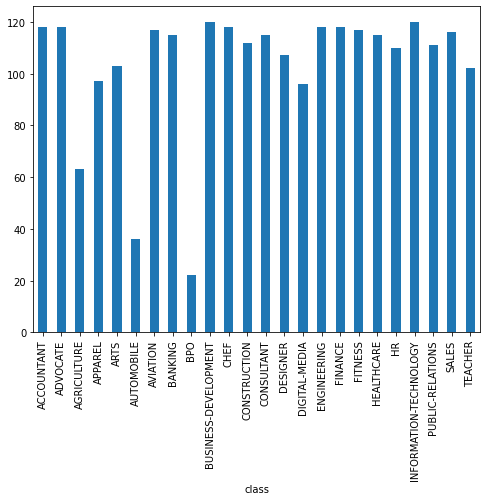

In [7]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8,6))
df_new.groupby('class').text.count().plot.bar(ylim=0)
plt.show()

In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', 
                        encoding='latin-1', ngram_range=(1,2), stop_words='english')
features = tfidf.fit_transform(df_new.text).toarray()
labels = df_new.category_id
features.shape

(2484, 45706)

In [9]:
from sklearn.feature_selection import chi2
import numpy as np

N = 2
for Product, category_id in sorted(category_to_id.items()):
    features_chi2 = chi2(features, labels == category_id)
    indices = np.argsort(features_chi2[0])
    feature_names = np.array(tfidf.get_feature_names())[indices]
    unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
    bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
    print("# '{}':".format(Product))
    print("  . Most correlated unigrams:\n. {}".format('\n. '.join(unigrams[-N:])))
    print("  . Most correlated bigrams:\n. {}".format('\n. '.join(bigrams[-N:])))

# 'ACCOUNTANT':
  . Most correlated unigrams:
. ledger
. accountant
  . Most correlated bigrams:
. general ledger
. accountant summary
# 'ADVOCATE':
  . Most correlated unigrams:
. advocacy
. advocate
  . Most correlated bigrams:
. advocate professional
. advocate summary
# 'AGRICULTURE':
  . Most correlated unigrams:
. agricultural
. agriculture
  . Most correlated bigrams:
. agriculture education
. natural resources
# 'APPAREL':
  . Most correlated unigrams:
. merchandising
. apparel
  . Most correlated bigrams:
. apparel sales
. assistant buyer
# 'ARTS':
  . Most correlated unigrams:
. arts
. martial
  . Most correlated bigrams:
. language arts
. arts teacher
# 'AUTOMOBILE':
  . Most correlated unigrams:
. insureds
. automobile
  . Most correlated bigrams:
. injury claims
. liability claims
# 'AVIATION':
  . Most correlated unigrams:
. aircraft
. aviation
  . Most correlated bigrams:
. aviation supply
. aviation maintenance
# 'BANKING':
  . Most correlated unigrams:
. loan
. banking

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

X_train, X_test, y_train, y_test = train_test_split(df_new['text'], df_new['class'], random_state = 0, shuffle= True)

count_vect = CountVectorizer()

X_train_counts = count_vect.fit_transform(X_train)

tfidf_transformer = TfidfTransformer()

X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

clf = MultinomialNB().fit(X_train_tfidf, y_train)

In [11]:
X_test.iloc[25]

'GUEST LECTURER Accomplishments  Heart Zones Level 1 Personal Trainer Galter LifeCenter 2005 - Current DIANA DIMAS PAGE !2 North Park University 2011 Â\u200b Current Group Exercise Instructor Certifications: BOSU, Schwinn Cycling, Group Power, Group Step, Group Active, Group Core, Group Ride, R30, Group Groove, Shockwave, Arthritis Chair, Matter of Balnce Galter LifeCenter 2005 - Current North Park Univeristy 2013 Â\u200b‐ Current PUBLICATIONS AND PAPERS Building your Personal Fitness Strategy" Galter LifeCenter Member Newsletter 2010.  Experience Guest Lecturer  Company Name  Strength and Conditioning 2013, 2014 Personal Health 2014 Guest Speaker: Introduction to Sports Management.  Fitness Supervisor  January 2014  Galter LifeCenter 2010 Â\u200b Current Responsible for supervising and/or performing the day to day functions of the Fitness Specialists, Fitness Coaches, Interns, Fitness Consults and overall safety on the fitness floor. Hire, train, and evaluate fitness specialists and i

In [12]:
print(clf.predict(count_vect.transform([X_test.iloc[25]])))

['FITNESS']


In [13]:
df_new[df_new['text'].str.contains(X_test.iloc[25])]

,text,class,category_id
1725,GUEST LECTURER Accomplishments Heart Zones Le...,FITNESS,17


In [14]:
print(clf.predict(count_vect.transform([X_test.iloc[38]])))

['DESIGNER']


In [15]:
df_new[df_new['text'] == X_test.iloc[38]]

,text,class,category_id
1328,INTERIOR DESIGNER Summary A results oriented d...,DESIGNER,13


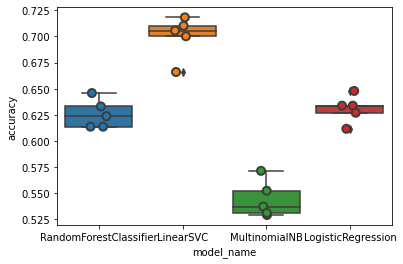

In [16]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])
import seaborn as sns
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

In [17]:
cv_df.groupby('model_name').accuracy.mean()

model_name
LinearSVC                 0.700083
LogisticRegression        0.630836
MultinomialNB             0.544287
RandomForestClassifier    0.626009
Name: accuracy, dtype: float64

In [18]:
category_id_df.head()

,class,category_id
0,ACCOUNTANT,0
118,ADVOCATE,1
236,AGRICULTURE,2
299,APPAREL,3
396,ARTS,4


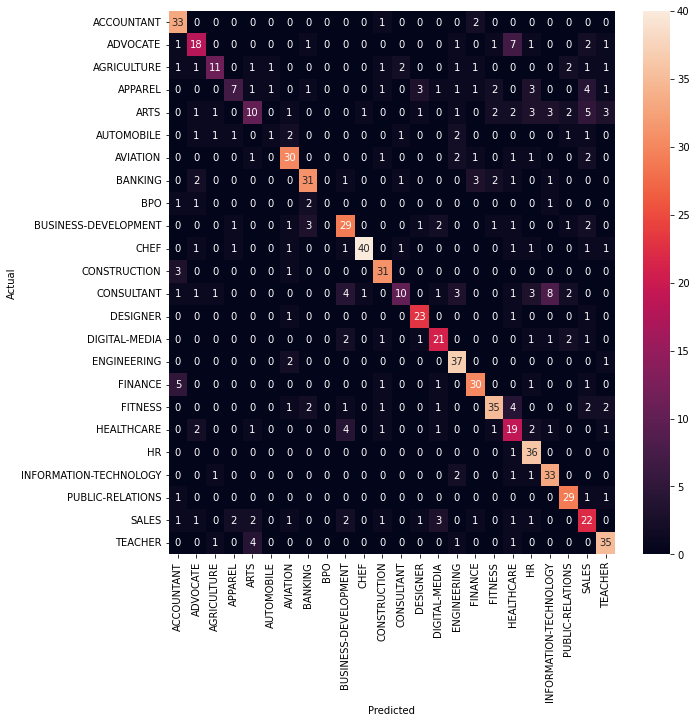

In [19]:
model = LinearSVC()
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, df_new.index, test_size=0.33, random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=category_id_df["class"].values, yticklabels=category_id_df["class"].values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [20]:
from IPython.display import display

for predicted in category_id_df.category_id:
    
    for actual in category_id_df.category_id:
       
        if predicted != actual and conf_mat[actual, predicted] >= 5:
            
            print("'{}' predicted as '{}' : {} examples.".format(id_to_category[actual], id_to_category[predicted], conf_mat[actual, predicted]))
            display(df.loc[indices_test[(y_test == actual) & (y_pred == predicted)]][['class', 'text']])
            print('')

'FINANCE' predicted as 'ACCOUNTANT' : 5 examples.


,class,text
1680,FINANCE,"AVP, FINANCE Summary Accounting professional ..."
1597,FINANCE,"FINANCE ASSISTANT Summary Accurate, Alert, Amb..."
1646,FINANCE,FINANCE CUSTOMER CARE REP LEAD Summary Proper...
1636,FINANCE,FINANCE SPECIALIST Summary To be able to join ...
1635,FINANCE,FINANCE MANAGER Summary Flexible Financial Ma...



'ADVOCATE' predicted as 'HEALTHCARE' : 7 examples.


,class,text
224,ADVOCATE,CHARGE NURSE Professional Summary Objective: ...
148,ADVOCATE,CUSTOMER SERVICE AGENT Professional Summary T...
182,ADVOCATE,REGISTERED NURSE CLINICAL CARE COORDINATOR- FI...
132,ADVOCATE,PHLEBOTOMIST Professional Summary Reliable and...
157,ADVOCATE,INTERN Professional Summary Client Negotiatio...
175,ADVOCATE,VICE PRESIDENT Executive Profile Accomplished...
187,ADVOCATE,PATIENT ADVOCATE Career Overview Skilled medic...



'CONSULTANT' predicted as 'INFORMATION-TECHNOLOGY' : 8 examples.


,class,text
1222,CONSULTANT,CONSULTANT Career Overview Macintosh Expert w...
1175,CONSULTANT,CONSULTANT Summary I am an experienced Program...
1146,CONSULTANT,IT CONSULTANT Professional Summary Support Eng...
1187,CONSULTANT,CONSULTANT Summary Master's degree in Compute...
1235,CONSULTANT,WMS CONSULTANT Objective Looking for the posi...
1166,CONSULTANT,"Qualifications Microsoft Office Specialist, Sy..."
1213,CONSULTANT,"CONSULTANT Summary PC Technician, Security Ana..."
1226,CONSULTANT,CONSULTANT Summary In-depth knowledge and unde...



'ARTS' predicted as 'SALES' : 5 examples.


,class,text
438,ARTS,SUMMER CAMP COUNSELOR Summary I have a Veteri...
480,ARTS,ACTING GRADE 4 CUSTOMER/BRAND Profile Obtain ...
465,ARTS,AM- REPLENISHMENT STOCKER Summary Adaptable [J...
461,ARTS,CERTIFIED CUSTOM FRAMER Qualifications Abilit...
444,ARTS,INSIDE ACCOUNT MANAGER Summary Inside Accoun...


In [21]:
model.fit(features, labels)
N = 2
for Product, category_id in sorted(category_to_id.items()):
    indices = np.argsort(model.coef_[category_id])
    feature_names = np.array(tfidf.get_feature_names())[indices]
    unigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 1][:N]
    bigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 2][:N]
    print("# '{}':".format(Product))
    print("  . Top unigrams:\n       . {}".format('\n       . '.join(unigrams)))
    print("  . Top bigrams:\n       . {}".format('\n       . '.join(bigrams)))


# 'ACCOUNTANT':
  . Top unigrams:
       . accountant
       . accounting
  . Top bigrams:
       . accountant summary
       . accountant company
# 'ADVOCATE':
  . Top unigrams:
       . advocate
       . advocacy
  . Top bigrams:
       . advocate summary
       . service advocate
# 'AGRICULTURE':
  . Top unigrams:
       . agriculture
       . agricultural
  . Top bigrams:
       . natural resources
       . research assistant
# 'APPAREL':
  . Top unigrams:
       . apparel
       . merchandising
  . Top bigrams:
       . key holder
       . product development
# 'ARTS':
  . Top unigrams:
       . arts
       . martial
  . Top bigrams:
       . arts teacher
       . language arts
# 'AUTOMOBILE':
  . Top unigrams:
       . automobile
       . auto
  . Top bigrams:
       . manager company
       . liability claims
# 'AVIATION':
  . Top unigrams:
       . aviation
       . aircraft
  . Top bigrams:
       . aviation supply
       . state aviation
# 'BANKING':
  . Top unigrams:
       

In [22]:
from sklearn import metrics
print(metrics.classification_report(y_test, y_pred, target_names=df['class'].unique()))

                        precision    recall  f1-score   support

            ACCOUNTANT       0.70      0.92      0.80        36
              ADVOCATE       0.62      0.55      0.58        33
           AGRICULTURE       0.69      0.46      0.55        24
               APPAREL       0.58      0.26      0.36        27
                  ARTS       0.50      0.28      0.36        36
            AUTOMOBILE       0.33      0.09      0.14        11
              AVIATION       0.73      0.77      0.75        39
               BANKING       0.78      0.74      0.76        42
                   BPO       0.00      0.00      0.00         5
  BUSINESS-DEVELOPMENT       0.66      0.69      0.67        42
                  CHEF       0.95      0.82      0.88        49
          CONSTRUCTION       0.78      0.89      0.83        35
            CONSULTANT       0.67      0.28      0.39        36
              DESIGNER       0.77      0.88      0.82        26
         DIGITAL-MEDIA       0.68      

/home/kguttas/anaconda3/envs/practica/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
